In [1]:
import joblib

data_records = joblib.load("data_records.pkl")

In [2]:
import numpy as np


# Define a function to assign labels based on fat percentage ranges
def assign_label(fat_percent):
    if fat_percent <= 5:
        return 0  # Label for fat percentage range 0-5
    elif fat_percent <= 33:
        return 1  # Label for fat percentage range 5-33
    elif fat_percent <= 66:
        return 2  # Label for fat percentage range 33-66
    else:
        return 3  # Label for fat percentage >66

In [8]:
def create_rgb(image):
    return np.stack((image,) * 3, axis=-1)

In [3]:
data_records['grade'] = np.vectorize(assign_label)(data_records['fat'])

In [9]:
X = data_records["images"]
X = np.array([create_rgb(img) for img in X])

y = np.array(data_records['grade'])

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

In [11]:
print(X_train[0].shape)

(400, 630, 3)


In [12]:
from sklearn import preprocessing
import tensorflow as tf


le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [13]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [14]:
X_test.shape

(182, 400, 630, 3)

In [15]:
from keras.applications import vgg16

img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

In [16]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [17]:
from keras.layers import Dense, GlobalAveragePooling2D


def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [18]:
from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 630, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 630, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 630, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 315, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 315, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 315, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 157, 128)     0     

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

Epoch 1/5
14/14 [==============================] - 125s 9s/step - loss: 0.9639 - accuracy: 0.5977 - val_loss: 0.8603 - val_accuracy: 0.6909
Epoch 2/5
14/14 [==============================] - 130s 9s/step - loss: 0.6627 - accuracy: 0.7227 - val_loss: 0.7183 - val_accuracy: 0.6727
Epoch 3/5
14/14 [==============================] - 130s 9s/step - loss: 0.6143 - accuracy: 0.7409 - val_loss: 0.7507 - val_accuracy: 0.6636
Epoch 4/5
14/14 [==============================] - 130s 9s/step - loss: 0.5187 - accuracy: 0.7909 - val_loss: 0.8426 - val_accuracy: 0.6364
Epoch 5/5
14/14 [==============================] - 133s 10s/step - loss: 0.3580 - accuracy: 0.8659 - val_loss: 0.8557 - val_accuracy: 0.6818


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)


4/4 [==============================] - 26s 6s/step
Confusion Matrix:
[[32  4  0  0]
 [11 26  0  1]
 [ 3  8  0  5]
 [ 1  2  0 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        36
           1       0.65      0.68      0.67        38
           2       0.00      0.00      0.00        16
           3       0.74      0.85      0.79        20

    accuracy                           0.68       110
   macro avg       0.52      0.61      0.56       110
weighted avg       0.58      0.68      0.63       110


Accuracy: 0.6818181818181818


c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [21]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
print(X_train[0].shape)

(400, 630, 3)


In [23]:
from sklearn import preprocessing
import tensorflow as tf


le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [24]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [25]:
X_test.shape

(110, 400, 630, 3)

In [26]:
from keras.applications import vgg16

img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

In [27]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [28]:
from keras.layers import Dense, GlobalAveragePooling2D


def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [29]:
from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 630, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 630, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 630, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 315, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 315, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 315, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 157, 128)     0   

In [30]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

Epoch 1/5
14/14 [==============================] - 521s 37s/step - loss: 1.6637 - accuracy: 0.3386 - val_loss: 1.1931 - val_accuracy: 0.4636
Epoch 2/5
14/14 [==============================] - 689s 50s/step - loss: 1.1429 - accuracy: 0.4864 - val_loss: 1.0578 - val_accuracy: 0.5636
Epoch 3/5
14/14 [==============================] - 552s 39s/step - loss: 1.0331 - accuracy: 0.5091 - val_loss: 0.9938 - val_accuracy: 0.6091
Epoch 4/5
14/14 [==============================] - 489s 36s/step - loss: 0.8651 - accuracy: 0.6273 - val_loss: 0.8834 - val_accuracy: 0.6091
Epoch 5/5
14/14 [==============================] - 165s 12s/step - loss: 0.8490 - accuracy: 0.5955 - val_loss: 0.7771 - val_accuracy: 0.6727


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)


4/4 [==============================] - 40s 11s/step
Confusion Matrix:
[[26  9  1  0]
 [ 2 35  0  1]
 [ 0 10  0  6]
 [ 0  7  0 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        36
           1       0.57      0.92      0.71        38
           2       0.00      0.00      0.00        16
           3       0.65      0.65      0.65        20

    accuracy                           0.67       110
   macro avg       0.54      0.57      0.54       110
weighted avg       0.62      0.67      0.63       110


Accuracy: 0.6727272727272727


In [32]:
model.layers

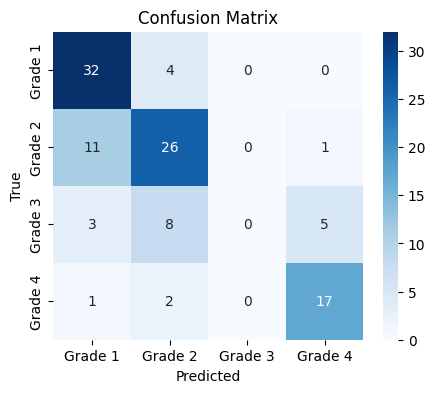

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
def display_conf_matrix(conf_matrix):
    # Plot the confusion matrix
    class_names = ["Grade 1", "Grade 2", "Grade 3", "Grade 4"]
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

display_conf_matrix(conf_matrix)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)


img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)


for layer in vgg.layers:
    layer.trainable = False

for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)



def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    # top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model




num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 630, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 630, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 630, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 315, 64)      0         
                                                             

In [43]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Preprocess the labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Increase epochs if needed
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20
14/14 [==============================] - 121s 9s/step - loss: 1.9542 - accuracy: 0.3455 - val_loss: 1.2726 - val_accuracy: 0.4364
Epoch 2/20
14/14 [==============================] - 129s 9s/step - loss: 1.1781 - accuracy: 0.4864 - val_loss: 1.1087 - val_accuracy: 0.5364
Epoch 3/20
14/14 [==============================] - 130s 9s/step - loss: 1.0710 - accuracy: 0.5295 - val_loss: 0.9267 - val_accuracy: 0.6818
Epoch 4/20
14/14 [==============================] - 131s 9s/step - loss: 0.8929 - accuracy: 0.6295 - val_loss: 1.0251 - val_accuracy: 0.5545
Epoch 5/20
14/14 [==============================] - 148s 11s/step - loss: 0.9614 - accuracy: 0.5568 - val_loss: 0.9167 - val_accuracy: 0.5636
Epoch 6/20
14/14 [==============================] - 292s 21s/step - loss: 0.8633 - accuracy: 0.6409 - val_loss: 0.9415 - val_accuracy: 0.5909
Epoch 7/20
14/14 [==============================] - 179s 12s/step - loss: 0.7262 - accuracy: 0.7091 - val_loss: 0.7659 - val_accuracy: 0.7000
Epoch 8/20

In [48]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def display_pred_results(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    class_report = classification_report(y_true_labels, y_pred_labels)

    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    print("\nClassification Report:")
    print(class_report)
    print("\nAccuracy:", accuracy)
    display_conf_matrix(conf_matrix)

4/4 [==============================] - 22s 5s/step
Confusion Matrix:
[[32  2  2  0]
 [ 3 30  4  1]
 [ 1  7  4  4]
 [ 0  1  3 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.75      0.79      0.77        38
           2       0.31      0.25      0.28        16
           3       0.76      0.80      0.78        20

    accuracy                           0.75       110
   macro avg       0.68      0.68      0.68       110
weighted avg       0.73      0.75      0.74       110


Accuracy: 0.7454545454545455


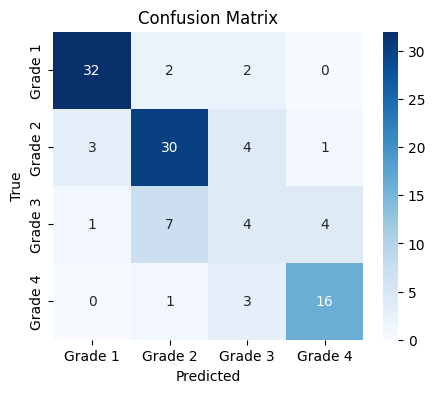

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)
display_conf_matrix(conf_matrix)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Load and preprocess the dataset (replace 'X' and 'y' with your dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocess the labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Load pre-trained VGG16 model
img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with data augmentation and early stopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/20
13/13 [==============================] - 128s 9s/step - loss: 1.7842 - accuracy: 0.3250 - val_loss: 1.3212 - val_accuracy: 0.3455
Epoch 2/20
13/13 [==============================] - 132s 10s/step - loss: 1.3636 - accuracy: 0.3455 - val_loss: 1.2982 - val_accuracy: 0.3455
Epoch 3/20
13/13 [==============================] - 131s 10s/step - loss: 1.2749 - accuracy: 0.3432 - val_loss: 1.2616 - val_accuracy: 0.4000
Epoch 4/20
13/13 [==============================] - 131s 10s/step - loss: 1.2192 - accuracy: 0.4136 - val_loss: 1.3398 - val_accuracy: 0.3455
Epoch 5/20
13/13 [==============================] - 132s 10s/step - loss: 1.2221 - accuracy: 0.4273 - val_loss: 1.2730 - val_accuracy: 0.3545
Epoch 6/20
13/13 [==============================] - 131s 10s/step - loss: 1.1938 - accuracy: 0.4409 - val_loss: 1.1357 - val_accuracy: 0.4545
Epoch 7/20
13/13 [==============================] - 131s 10s/step - loss: 1.2086 - accuracy: 0.4273 - val_loss: 1.1595 - val_accuracy: 0.4091
Epoch 8

4/4 [==============================] - 25s 6s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.92      0.72        36
           1       0.50      0.42      0.46        38
           2       0.20      0.06      0.10        16
           3       0.71      0.60      0.65        20

    accuracy                           0.56       110
   macro avg       0.50      0.50      0.48       110
weighted avg       0.52      0.56      0.52       110


Accuracy: 0.5636363636363636


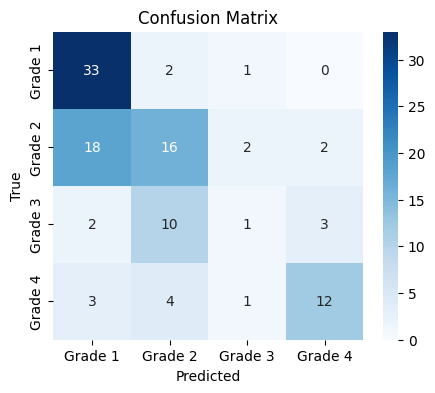

In [51]:
display_pred_results(model, X_test, y_test)

import joblib as jb

In [50]:
jb.dump(model, "..\models\\vgg16_data_aug.pkl")


['..\\models\\vgg16_data_aug.pkl']